<a href="https://colab.research.google.com/github/ulischlickewei/Mathe2-DS/blob/main/20240613_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture PCA

Content credit: This notebook has been prepared by the teaching staff of Berkeley's Data Science 100 class.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yaml
from datetime import datetime

np.random.seed(23) #kallisti

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

# Congressional Vote Data

Let's examine how the House of Representatives (of the 116th Congress, 1st session) voted in the month of **September 2019**.

From the [U.S. Senate website](https://www.senate.gov/reference/Index/Votes.htm):

> Roll call votes occur when a representative or senator votes "yea" or "nay," so that the names of members voting on each side are recorded. A voice vote is a vote in which those in favor or against a measure say "yea" or "nay," respectively, without the names or tallies of members voting on each side being recorded.

The data, compiled from ProPublica [source](https://github.com/eyeseast/propublica-congress), is a "skinny" table of data where each record is a single vote by a member across any roll call in the 116th Congress, 1st session, as downloaded in February 2020. The member of the House, whom we'll call **legislator**, is denoted by their bioguide alphanumeric ID in http://bioguide.congress.gov/.

In [3]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
url_votes = 'https://raw.githubusercontent.com/ulischlickewei/Mathe2-DS/main/votes.csv'
votes = pd.read_csv(url_votes)
votes = votes.astype({"roll call": str})
votes

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No
...,...,...,...,...,...
17823,House,1,515,Y000062,Yes
17824,House,1,515,Y000065,No
17825,House,1,515,Y000033,Yes
17826,House,1,515,Z000017,Yes


Suppose we pivot this table to group each legislator and their voting pattern across every (roll call) vote in this month. We mark 1 if the legislator voted Yes (yea), and 0 otherwise (No/nay, no vote, speaker, etc.).

In [4]:
def was_yes(s):
    return 1 if s.iloc[0] == "Yes" else 0

vote_pivot = votes.pivot_table(index='member',
                                columns='roll call',
                                values='vote',
                                aggfunc=was_yes,
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()

(441, 41)


roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,0,1
A000369,1,1,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1


How do we analyze this data?

While we could consider loading information about the legislator, such as their party, and see how this relates to their voting pattern, it turns out that we can do a lot with PCA to cluster legislators by how they vote.

## PCA

In [5]:
vote_pivot_centered = vote_pivot - np.mean(vote_pivot, axis = 0)
vote_pivot_centered.head(5)

roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,0.129252,-0.668934,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000367,-0.870748,-0.668934,-0.526077,-0.52381,-0.950113,-0.412698,-0.562358,-0.365079,-0.405896,-0.439909,...,-0.521542,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,-0.913832,0.496599
A000369,0.129252,0.331066,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000370,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599
A000371,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599


In [6]:
vote_pivot_centered.shape

(441, 41)

In [11]:
X = vote_pivot_centered.to_numpy().T
X

array([[ 0.1292517 , -0.8707483 ,  0.1292517 , ...,  0.1292517 ,
        -0.8707483 ,  0.1292517 ],
       [-0.66893424, -0.66893424,  0.33106576, ...,  0.33106576,
        -0.66893424,  0.33106576],
       [-0.5260771 , -0.5260771 , -0.5260771 , ...,  0.4739229 ,
        -0.5260771 , -0.5260771 ],
       ...,
       [-0.53514739,  0.46485261, -0.53514739, ...,  0.46485261,
        -0.53514739, -0.53514739],
       [ 0.0861678 , -0.9138322 ,  0.0861678 , ...,  0.0861678 ,
         0.0861678 ,  0.0861678 ],
       [-0.50340136,  0.49659864, -0.50340136, ...,  0.49659864,
        -0.50340136, -0.50340136]])

In [12]:
X.shape

(41, 441)

In [15]:
XXt = X.dot(X.T)
XXt

array([[ 49.63265306,  36.1292517 ,  17.98639456, ...,  18.50340136,
         10.08843537,  17.69387755],
       [ 36.1292517 ,  97.66439909,  63.80725624, ...,  63.13151927,
          9.41950113,  61.49659864],
       [ 17.98639456,  63.80725624, 109.95011338, ...,  99.84580499,
          6.99092971, 103.21088435],
       ...,
       [ 18.50340136,  63.13151927,  99.84580499, ..., 109.70521542,
         14.33560091, 103.19727891],
       [ 10.08843537,   9.41950113,   6.99092971, ...,  14.33560091,
         34.72562358,  15.1292517 ],
       [ 17.69387755,  61.49659864, 103.21088435, ..., 103.19727891,
         15.1292517 , 110.24489796]])

In [16]:
XXt.shape

(41, 41)

In [29]:
# compute eigenvalues and eigenvectors = principal comoponents
eigenvalues, principal_components = np.linalg.eig(XXt)

In [ ]:
# sort eigenvalues and principal components
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
principal_components = principal_components[:,sorted_indices]

## Projecting the data to principal components

Let's project our data to PC1 and PC2 and plot the result.

In [41]:
projection = principal_components[:,:2].T.dot(X)

In [46]:
projection.shape

(2, 441)

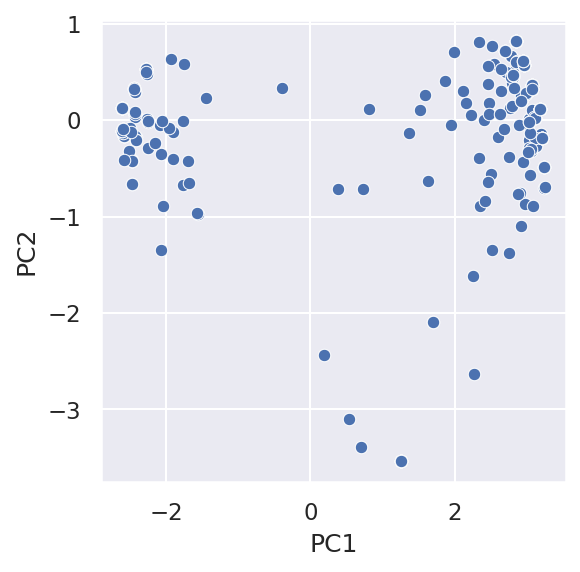

In [48]:
sns.scatterplot(x=projection[0,:], y=projection[1,:]);
plt.xlabel("PC1");
plt.ylabel("PC2");

Baesd on the plot above, it looks like there are two clusters of datapoints. What do you think this corresponds to?

## Incorporating Member Information

Suppose we load in more member information, from https://github.com/unitedstates/congress-legislators. This includes each legislator's political party.

In [49]:
legislators_url = 'https://raw.githubusercontent.com/ulischlickewei/Mathe2-DS/main/legislators-current.yaml'
import requests
r = requests.get(legislators_url)
legislators_data = yaml.safe_load(r.content)

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'],
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.set_index("leg_id")
legs.sort_index()

,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05
3,C000174,Thomas,Carper,M,DE,sen,Democrat,1947-01-23
4,C001070,Robert,Casey,M,PA,sen,Democrat,1960-04-13
...,...,...,...,...,...,...,...,...
534,M001197,Martha,McSally,F,AZ,sen,Republican,1966-03-22
535,G000592,Jared,Golden,M,ME,rep,Democrat,1982-07-25
536,K000395,Fred,Keller,M,PA,rep,Republican,1965-10-23
537,B001311,Dan,Bishop,M,NC,rep,Republican,1964-07-01


<br/><br/>

---

Let's check out how party affiliations relate to the PC1, PC2 transformation from earlier:

First, let's see which party has negative PC1 scores.

In [50]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': projection[0, :],
    'pc2': projection[1, :]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d[vote2d['pc1'] < 0]['party'].value_counts()

party
Democrat    231
Name: count, dtype: int64

Hm let's keep checking things out.

We didn't cover the query syntax that we use below, but if you're curious, check out the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html).

In [51]:
#top right only
vote2d.query('pc2 > -2 and pc1 > 0')['party'].value_counts()

party
Republican    194
Name: count, dtype: int64


<br/><br/>


Interesting. Let's use these party labels to color our principal components:

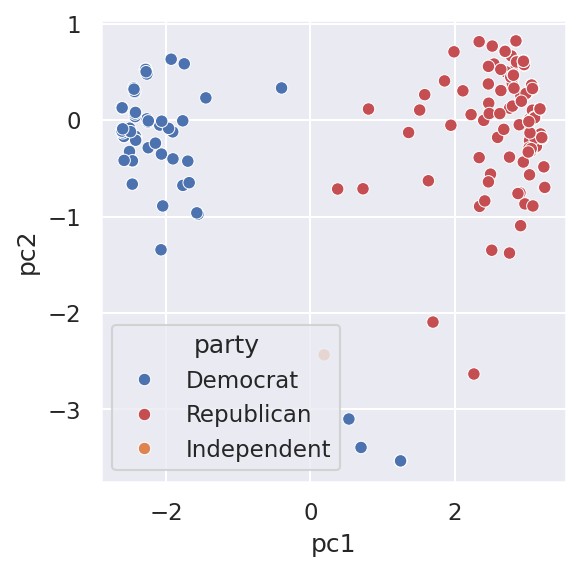

In [52]:

cp = sns.color_palette()
party_cp = [cp[i] for i in [0, 3, 1]]
party_hue = ["Democrat", "Republican", "Independent"]

sns.scatterplot(x="pc1", y="pc2",
                hue="party", palette=party_cp,  hue_order=party_hue,
                data = vote2d);

There seems to be a bunch of overplotting, so let's jitter a bit.

In [54]:
vote2d['pc1_jittered'] = vote2d['pc1'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])
vote2d['pc2_jittered'] = vote2d['pc2'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])

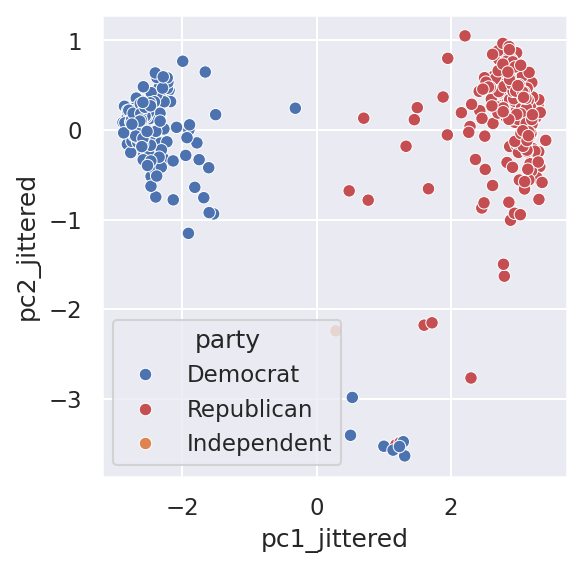

In [55]:
sns.scatterplot(x="pc1_jittered", y="pc2_jittered",
                hue="party", palette=party_cp,  hue_order=party_hue,
                data = vote2d);